In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
from tqdm import tqdm
import warnings

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch import Tensor
import torchvision.models as models

from scipy.signal import find_peaks, detrend, butter, filtfilt, fftconvolve

In [2]:
# Where the data is saved
data_dir = '/DATA_DIR'

# Where the tensor will be saved
tensor_dir = '/TENSOR_DIR'

# Load in data

In [3]:
df = pd.read_csv('./indexed_df.csv')

In [4]:
doppler = torch.zeros(len(df),2,30000)

In [5]:
for row in tqdm(range(len(df))):
    biopac_idx = df.loc[row,'biopac_clip_idx']
    doppler_id = df.loc[row,'doppler_id']
    dp = pd.read_csv(f'{data_dir}/{biopac_idx}/{doppler_id}{biopac_idx}.csv')
    dp = torch.tensor(dp.values).float()
    doppler[row] = dp.T

100%|██████████| 10489/10489 [01:12<00:00, 143.79it/s]


In [6]:
torch.save(doppler, tensor_dir+'/doppler.pt')

In [7]:
biopac_idx = df['biopac_clip_idx'].unique().tolist()
biopac = torch.zeros(max(biopac_idx)+1,7500)

for idx in tqdm(biopac_idx):
    bp = pd.read_csv(f'{data_dir}/{idx}/BIOPAC_{idx}.csv', usecols=[2])
    bp = torch.tensor(bp.values).float().squeeze()
    biopac[idx,:] = bp

100%|██████████| 1399/1399 [00:04<00:00, 328.21it/s]


In [8]:
biopac_idx = df['biopac_clip_idx'].unique().tolist()
biopac_rr = torch.zeros(max(biopac_idx)+1,7500)

for idx in tqdm(biopac_idx):
    bp = pd.read_csv(f'{data_dir}/{idx}/BIOPAC_{idx}.csv', usecols=[1])
    bp = torch.tensor(bp.values).float().squeeze()
    biopac_rr[idx,:] = bp

100%|██████████| 1399/1399 [00:04<00:00, 333.19it/s]


In [9]:
torch.save(biopac, tensor_dir+'/biopac.pt')
torch.save(biopac_rr, tensor_dir+'/biopac_rr.pt')

# Load in BIOPAC

In [10]:
biopac = torch.load(tensor_dir+'/biopac.pt').numpy()
biopac_processed = np.zeros_like(biopac)
biopac_peak = np.zeros_like(biopac)

(1503, 7500)


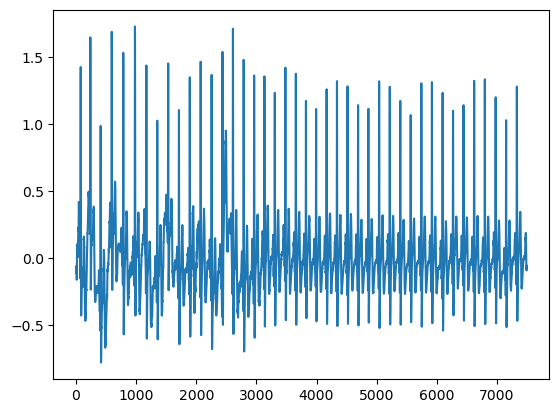

In [11]:
# change i here to check if data looks correct
i = 1000

plt.plot(biopac[i])
print(biopac.shape)

# preprocessing

In [12]:
for i in tqdm(range(biopac.shape[0])):
    bp = biopac[i,:]
    if bp.sum() == 0:
        continue
    std = bp.std()
    m = bp.mean()
    bp_max = bp.max()
    peak = find_peaks(bp, height=min(m+std*2,bp_max-std), distance=0.25*250)[0]
    num_beats = len(peak)
    peak = find_peaks(bp, height=min(m+std*2,bp_max-std), distance=15/num_beats*250/2)[0]
    biopac_processed[i,:] = bp
    biopac_peak[i,peak]=1

100%|██████████| 1503/1503 [00:00<00:00, 2761.70it/s]


In [13]:
# each heart beat should be at least 0.20s / 50 datapoints apart (5 beats per sec absolute max should not even happen)

for i in tqdm(range(biopac_peak.shape[0])):
    j = 0
    while j < biopac_peak.shape[1]:
        if biopac_peak[i,j]==1:
            biopac_peak[i,j+1:j+50] = 0
            j += 50
        else:
            j += 1

100%|██████████| 1503/1503 [00:36<00:00, 41.25it/s]


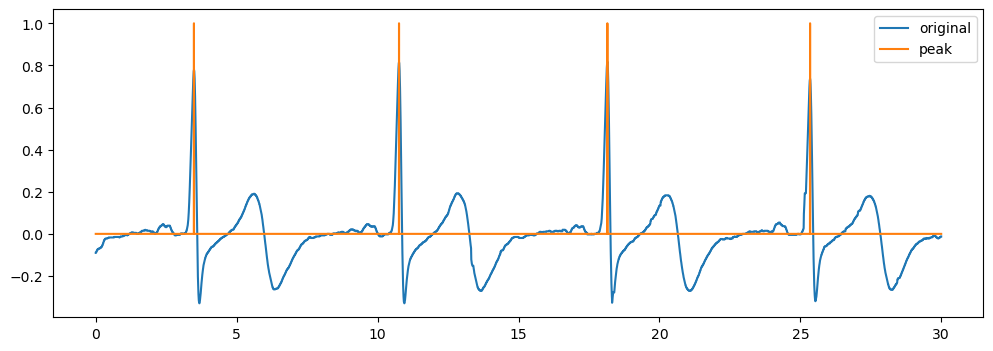

In [14]:
# 
i = 709

fig,ax = plt.subplots(figsize=(12,4))

ax.plot(np.arange(0,30,1/250),biopac[i], label='original')
ax.plot(np.arange(0,30,1/250),biopac_peak[i], label='peak')
ax.legend();

In [15]:
torch.save(biopac_peak, tensor_dir+'/biopac_peak.pt')

# Update df and remove anomaly

In [16]:
peak_sum = biopac_peak.sum(axis=1)*2

In [17]:
only_once = np.where((peak_sum < 30) & (peak_sum > 0))[0]
print(only_once)

[315 316 317 318 319 320 321 322 323 325 326 327 328 329 330 331 332 333
 335 336 337 338 339 340 341 342 343 345 346 347 348 349 350 351 352 353
 355 356 357 358 359 360 361 362 363 365 366 367 368 369 370 371 372 373
 375 376 377 378 379 380 381 382 383 385 386 387 388 389 391 392 393 521
 553 554 555 667 668 669 670 672 673 674 675 676 677 678 679 680 682 683
 684 685 686 687 688 689 690 692 693 694 695 696 697 698 699 700 702 703
 704 705 706 707 708 709 710 713 714 715 716 717 718 719 720 722 723 724
 725 726 727 728 729 730 731 733 734 735 736 737 738 739 740 741 743 744
 745 746]


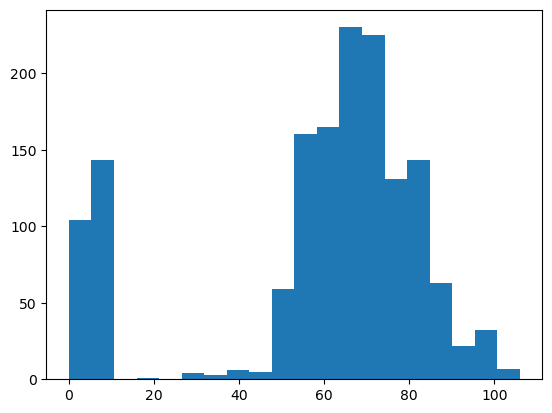

In [18]:
plt.hist(peak_sum,bins=20);

In [19]:
exclude_idx = df['biopac_clip_idx'].isin(only_once)
df['exclude'] = False
df['exclude_reason'] = 'N/A'
df.loc[exclude_idx,'exclude'] = True
df.loc[exclude_idx,'exclude_reason'] = 'Heart rate too low'
df.loc[exclude_idx,'hr'] = 0

## Calculate heart rate

In [20]:
for i in range(biopac_peak.shape[0]):
    bp = biopac_peak[i]
    if bp.sum() < 15:
        continue
    df_idx = (df['biopac_clip_idx']==i)
    peaks = np.where(bp==1)[0]
    avg_interval = (peaks[1:] - peaks[:-1]).mean() / 250
    bpm = 60 / avg_interval
    df.loc[df_idx,'hr'] = bpm

In [21]:
df.to_csv('./indexed_df_hr.csv', index=False)

# Simplify indexing

In [22]:
df = df[df['exclude']==False].copy().reset_index(drop=True)

In [23]:
datapoint_idx = df.datapoint_idx.unique()
biopac_clip_idx = df.biopac_clip_idx.unique()

df['new_dp_idx'] = df['datapoint_idx'].apply(lambda x: np.where(datapoint_idx==x)[0][0])
df['new_bp_idx'] = df['biopac_clip_idx'].apply(lambda x: np.where(biopac_clip_idx==x)[0][0])

In [24]:
doppler = doppler[datapoint_idx]
biopac = biopac[biopac_clip_idx]
biopac_peak = biopac_peak[biopac_clip_idx]
biopac_rr = biopac_rr[biopac_clip_idx]

In [25]:
torch.save(doppler, tensor_dir+'/doppler.pt')
torch.save(biopac, tensor_dir+'/biopac.pt')
torch.save(biopac_peak, tensor_dir+'/biopac_peak.pt')
torch.save(biopac_rr, tensor_dir+'/biopac_rr.pt')

In [26]:
df.to_csv('./1_main_df.csv', index=False)

# Take top 4 standard deviation for case 2

In [27]:
biopac = torch.tensor(torch.load(tensor_dir+'/biopac.pt'))
biopac_rr = torch.load(tensor_dir+'/biopac_rr.pt')
biopac_peak = torch.tensor(torch.load(tensor_dir+'/biopac_peak.pt'))
doppler = torch.load(tensor_dir+'/doppler.pt')

In [28]:
mapping = {}
for i in df['new_bp_idx'].unique():
    mapping[i] = df[df['new_bp_idx']==i]['new_dp_idx'].tolist()
    
print(f'Num clips: {len(df)}')

Num clips: 10343


In [29]:
df['use_idx'] = None

In [30]:
num_dps = 4
num_data = (df['case_id']=='Case1').sum() + len(df[df['case_id']=='Case2']['biopac_clip_idx'].unique()) * num_dps

In [31]:
biopac_use = torch.zeros(num_data,7500)
biopac_rr_use = torch.zeros(num_data,7500)
biopac_peak_use = torch.zeros(num_data,7500)
doppler_use = torch.zeros(num_data, 2, 30000)

i = 0
j = 0
while i < biopac.shape[0]:
    dp_idx = mapping[i]
    if len(dp_idx) == 1:
        biopac_use[i] = biopac[i]
        biopac_rr_use[i] = biopac_rr[i]
        biopac_peak_use[i] = biopac_peak[i]
        doppler_use[dp_idx] = doppler[dp_idx]
        df.loc[i,'use_idx'] = i
        i += 1
        j += 1
    else:
        dp = doppler[dp_idx]
        dp_std = dp[:,0,:].std(axis=1) + dp[:,1,:].std(axis=1)
        top_k = torch.topk(dp_std,num_dps)[1]
        for k in range(num_dps):
            biopac_use[j] = biopac[i]
            biopac_rr_use[j] = biopac_rr[i]
            biopac_peak_use[j] = biopac_peak[i]
            doppler_use[j] = dp[top_k[k]]
            df.loc[dp_idx[top_k[k]],'use_idx'] = j
            j += 1
        i += 1

In [32]:
torch.save(biopac_use, tensor_dir+'/biopac_use.pt')
torch.save(biopac_rr_use, tensor_dir+'/biopac_rr_use.pt')
torch.save(biopac_peak_use, tensor_dir+'/biopac_peak_use.pt')
torch.save(doppler_use, tensor_dir+'/doppler_use.pt')

In [33]:
df = df[pd.isnull(df['use_idx'])==False].copy()
df = df.sort_values(['use_idx'])
df = df.reset_index(drop=True)

In [34]:
df.to_csv('./2_use_df.csv')

# Clean action

In [35]:
null_action = pd.isnull(df['action'])
df.loc[null_action,'action'] = 'Unknown'

In [36]:
action_map = {
    'SitStand': 'Sit to Stand',
    'Stand': 'Stand',
    'PseudoJump': 'Jump',
    'WalkinPlace': 'Walk in Place',
    'Sit': 'Sit',
    'CrouchLeft': 'Crouch',
    'CrouchRight': 'Crouch',
    'LieDown': 'Lie',
    'LieDown_Quilt': 'Lie with Blanket',
    'LieLeft': 'Lie',
    'LieRight': 'Lie',
    'LieUp': 'Lie',
    'LieUp_Quilt': 'Lie with Blanket',
    'Laydown': 'Lie',
    'Unknown': 'Unknown',
    'LieLeft_Quilt': 'Lie with Blanket',
    'LieRight_Quilt': 'Lie with Blanket',
    'LieUp_LeftSide': 'Lie',
    'LayDown': 'Lie',
    'PseudoJuump': 'Jump',
    'LayDown_Fan': 'Lie',
    'Clockwise': 'Walk in circle',
    'Pseudojump_LocC': 'Jump',
    'Pseudojump_LocD': 'Jump',
    'SitStand_LocC': 'Sit to Stand',
    'SitStand_LocD': 'Sit to Stand',
    'WalkinPlace_arms_LocC': 'Walk in Place',
    'WalkinPlace_arms_LocD': 'Walk in Place',
    'WalkinPlace_LocC': 'Walk in Place',
    'WalkinPlace_LocD': 'Walk in Place',
    'Stand_Back': 'Stand',
    'CounterClockwise': 'Walk in circle',
    'Pseudojump_LocG': 'Jump',
    'SitStand_LocG': 'Sit to Stand',
    'WalkinPlace_arms_LocG': 'Walk in Place',
    'WalkinPlace_LocG': 'Walk in Place',
    'Stand_Front': 'Stand',
}

In [37]:
df['action_clean'] = df['action'].apply(lambda x: action_map[x])

In [38]:
df.to_csv('./2_use_df.csv', index=False)

# Get respiration rate

In [39]:
biopac = torch.load(tensor_dir+'/biopac_use.pt')
biopac_rr = torch.load(tensor_dir+'/biopac_rr_use.pt')
biopac_peak = torch.load(tensor_dir+'/biopac_peak_use.pt')
doppler = torch.load(tensor_dir+'/doppler_use.pt')

In [40]:
# Remove abnomalies

is_zero = torch.nonzero(biopac_rr==0)
for [i,j] in tqdm(is_zero):
    biopac_rr[i,j] = biopac_rr[i,j-1]

100%|██████████| 292370/292370 [00:09<00:00, 31784.77it/s]


In [41]:
torch.save(biopac_rr, tensor_dir+'/biopac_rr_use.pt')

In [42]:
def bp_sig_denoise(sig, upper_bound, lower_bound):
    sig = fftconvolve(sig, np.ones(5)/5, mode='same')
    def small_sig_denoise(sig, upper_bound, lower_bound):
        upper_bound /= 60
        lower_bound /= 60
        sig_fft = np.fft.fft(sig)
        power = np.abs(sig_fft)**2
        N = len(sig)
        T = 1/250
        sig_freq = np.fft.fftfreq(N, T)
        pos_mask = np.where((sig_freq < upper_bound) & (sig_freq > lower_bound))
        freqs = sig_freq[pos_mask]
        mask_power = power[pos_mask]
        try:
            peak_freq = freqs[mask_power.argmax()]
        except:
            return sig, 0
        low_freq_fft = sig_fft.copy()
        low_freq_fft[np.abs(sig_freq) > min(upper_bound, peak_freq)] = 0
        sig_denoise = np.fft.ifft(low_freq_fft)
        return sig_denoise, 60*min(peak_freq, upper_bound)
    
    sig_denoise, rr = small_sig_denoise(sig, upper_bound, lower_bound)
    if rr > lower_bound and rr < upper_bound:
        return sig_denoise, rr
    
    # first half
    sig_denoise, rr = small_sig_denoise(sig[:3750], upper_bound, lower_bound)
    if rr > lower_bound and rr < upper_bound:
        return np.repeat(sig_denoise,2), rr
    # second half
    sig_denoise, rr = small_sig_denoise(sig[3750:], upper_bound, lower_bound)
    if rr > lower_bound and rr < upper_bound:
        return np.repeat(sig_denoise,2), rr
    
    # first third
    sig_denoise, rr = small_sig_denoise(sig[:2500], upper_bound, lower_bound)
    if rr > lower_bound and rr < upper_bound:
        return np.repeat(sig_denoise,3), rr
    # middle third
    sig_denoise, rr = small_sig_denoise(sig[2500:5000], upper_bound, lower_bound)
    if rr > lower_bound and rr < upper_bound:
        return np.repeat(sig_denoise,3), rr
    # last third
    sig_denoise, rr = small_sig_denoise(sig[2500:5000], upper_bound, lower_bound)
    return np.repeat(sig_denoise,3), rr

14.0


/nobackup/users/rduan/anaconda3/envs/torch3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


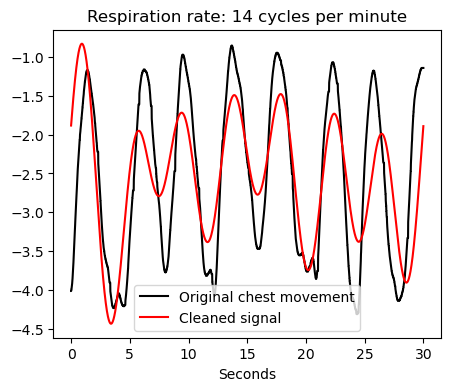

In [43]:
i = 1200

sig, rrate = bp_sig_denoise(biopac_rr[i],120,3)
print(rrate)

fig,ax = plt.subplots(figsize=(5,4))

ax.plot(np.arange(0,30,1/250), biopac_rr[i], label='Original chest movement', color='black')

ax.plot(np.arange(0,30,1/250), sig, label='Cleaned signal', color='red')
ax.legend()
ax.set_xlabel('Seconds')
ax.set_title(f'Respiration rate: {int(rrate)} cycles per minute');

In [44]:
df['rr'] = None

for i in tqdm(range(len(df))):
    _, rr = bp_sig_denoise(biopac_rr[i],120,3)
    df.loc[i,'rr'] = rr

 75%|███████▌  | 2056/2732 [00:01<00:00, 1079.53it/s]/nobackup/users/rduan/anaconda3/envs/torch3/lib/python3.9/site-packages/scipy/signal/signaltools.py:507: RuntimeWarning: invalid value encountered in multiply
  ret = ifft(sp1 * sp2, fshape, axes=axes)
100%|██████████| 2732/2732 [00:02<00:00, 1076.11it/s]


In [45]:
df.to_csv('./2_use_df.csv', index=False)

Text(0.5, 1.0, 'Histogram of heart rate')

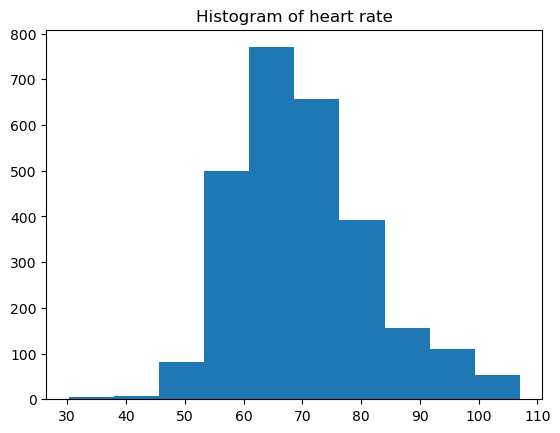

In [46]:
plt.hist(df['hr'],bins=10)
plt.title('Histogram of heart rate')